# CF Project 6.6: Sourcing & Analyzing Time-Series Data

## This script contains the following:

### 1. Importing your libraries and data
### 2. Subsetting, wrangling, and cleaning time-series data
### 3. Time series analysis: decomposition
### 4. Testing for stationarity
### 5. Stationarizing the Data
### 6. Checking for the data's autocorrelations

# 01. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight')

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'UVUQsxQByhcXysmqveSx'

In [3]:
# Importing the Federal Reserve Economic Data "Consumer Price Index for All Urban Consumers: All Items" variable.

data = quandl.get('FRED/CPIAUCSL')

In [4]:
# Checking output
data.head(5)

,Value
Date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


In [5]:
data.shape

(901, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

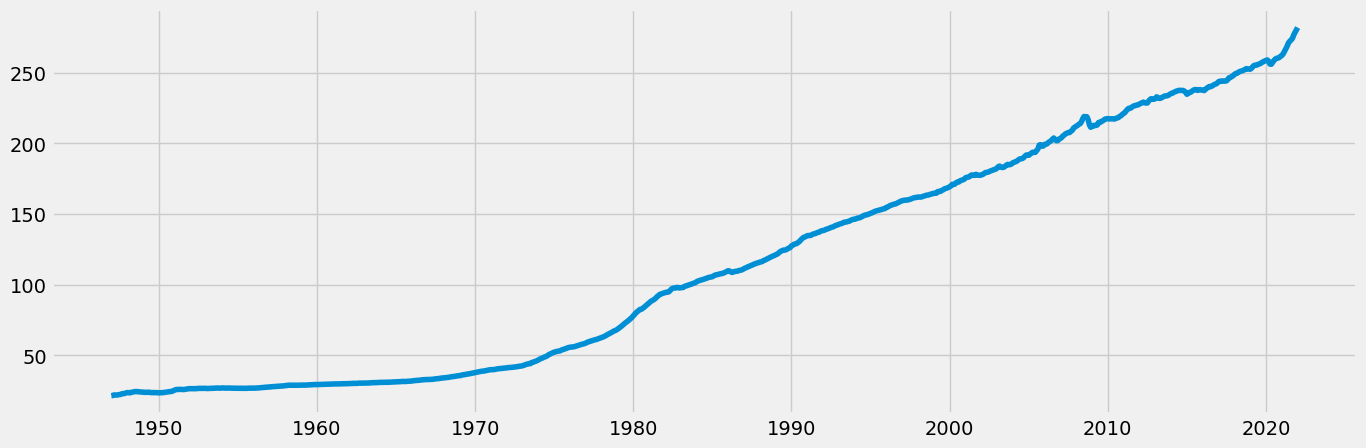

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot(data)

# 02. Subsetting, wrangling, and cleaning time-series data

In [9]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
# Checking output
data_2.head()

,Date,Value
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


In [11]:
# Creating a subset for necessary data
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2022-12-01')]

#### 1980-01-01 was chosen due to the fact that, like stated in the Exercise, economic conditions in the present are different than in the 50s to 80s, so including data for that time period would incorrectly influence the calculations, thereby creating bias.  2022-12-01 was chosen due to the fact that this is 2023 - anything before may result to an analysis which is not updated, anything after would be a prediction.
#### However, the graph below show that the data is till 2020, not upto 2022.

In [12]:
# Checking output
data_sub.shape

(505, 2)

In [13]:
data_sub.head()

,Date,Value
396,1980-01-01,78.0
397,1980-02-01,79.0
398,1980-03-01,80.1
399,1980-04-01,80.9
400,1980-05-01,81.7


In [14]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date"
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,78.0
1980-02-01,79.0
1980-03-01,80.1
1980-04-01,80.9
1980-05-01,81.7


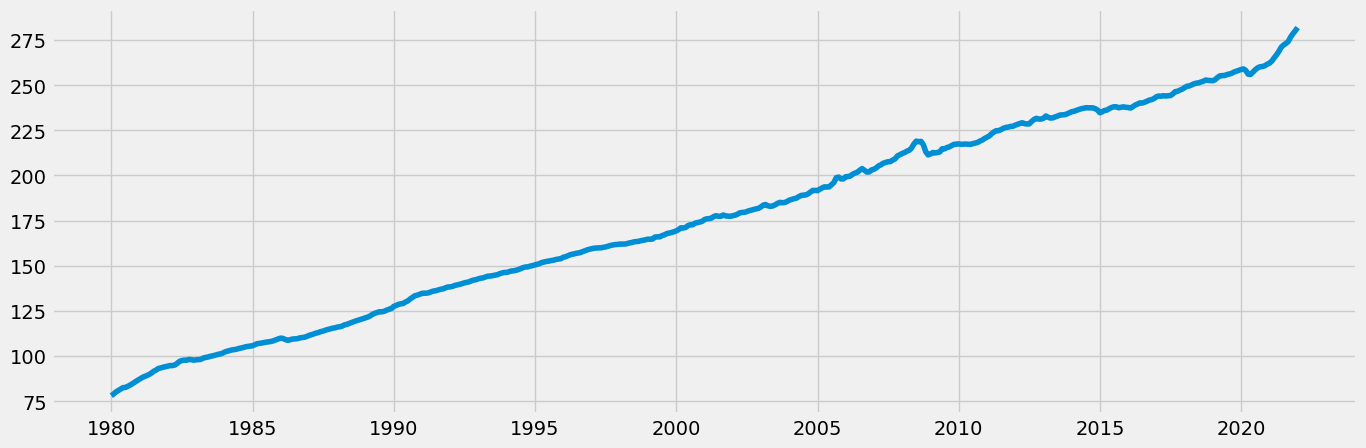

In [15]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [16]:
# Check for missing values

data_sub.isnull().sum() 

Value    0
dtype: int64

In [17]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

24

# 03. Time-series analysis: decomposition

In [18]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

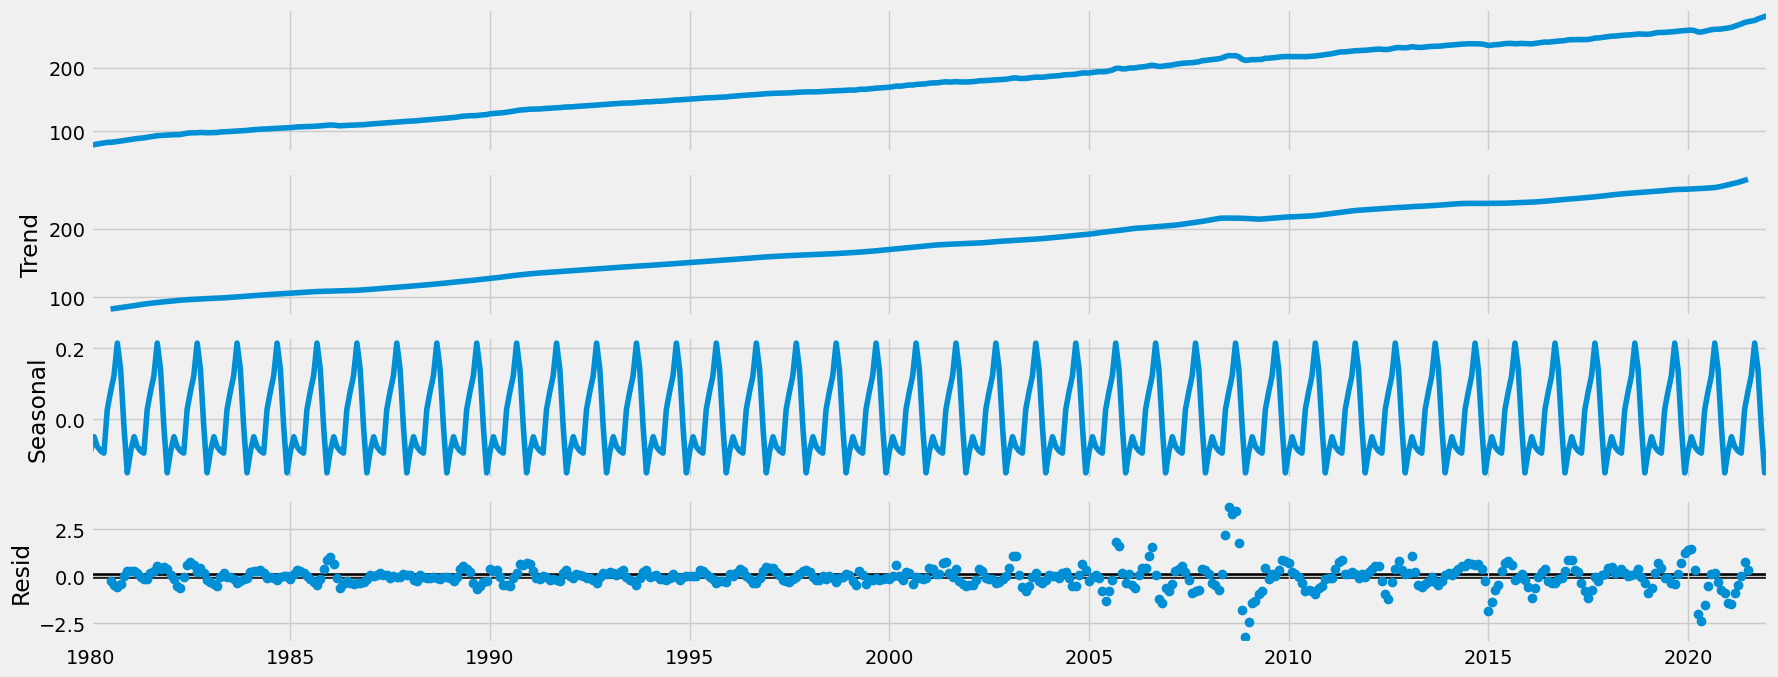

In [20]:
# Plot the separate components

decomposition.plot()
plt.show()

#### The trend is the same as the level, which shows that the data is not unsmoothed (does not have much noise). The trend is an upward dominant trend showing that the Consumer Price Index for All Urban Consumers: All Items increased slowly and steadily across the years.
#### The seasonality shows that seasonal fluctuations occur at regular intervals showing that the consumer price index goes down every year, with a spike occuring briefly before the year.
#### The residual confirms that the data does not have much noise, till between 2005 and 2009, which could be as a result of the global financial crisis.
#### The presence of trend and seasonality shows that the time series is non-stationary.

# 04. Testing for stationarity

In [21]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.313414
p-value                          0.996683
Number of Lags Used             15.000000
Number of Observations Used    489.000000
Critical Value (1%)             -3.443794
Critical Value (5%)             -2.867469
Critical Value (10%)            -2.569928
dtype: float64


#### The Test Statistic is larger than all the critical values. This implies that the null hypothesis, which states that there is a unit root in the data (non-stationary), cannot be disproved. This consequently means that the time series is non-stationary.

# 05. Stationarizing the Data

#### Stationarizing the data using the differencing technique

In [28]:
# Differencing technique
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [23]:
# Removing the missing values that came about as a result of the differencing.
data_diff.dropna(inplace = True)

In [24]:
data_diff.head()

,Value
datetime,
1980-02-01,1.0
1980-03-01,1.1
1980-04-01,0.8
1980-05-01,0.8
1980-06-01,0.8


In [25]:
data_diff.columns

Index(['Value'], dtype='object')

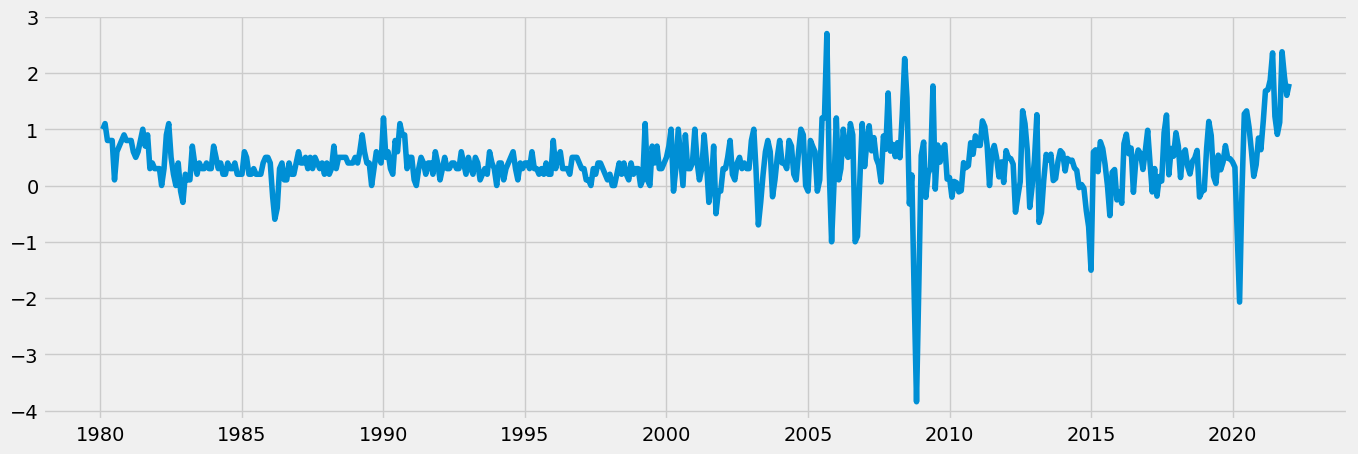

In [26]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [27]:
# Carry out the Dickey-Fuller Stationarity test for stationarity
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.344427
p-value                          0.013006
Number of Lags Used             14.000000
Number of Observations Used    489.000000
Critical Value (1%)             -3.443794
Critical Value (5%)             -2.867469
Critical Value (10%)            -2.569928
dtype: float64


#### The result above shows that the time series was successfully stationarized by the first differencing technique, as the Test Statistics is now smaller in value than the critical value at 5% significance level. Therefore, the null hypothesis can be disproved, and forecasting can be done as the time series is now stationary.

# 06. Checking for the data's autocorrelations

In [31]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

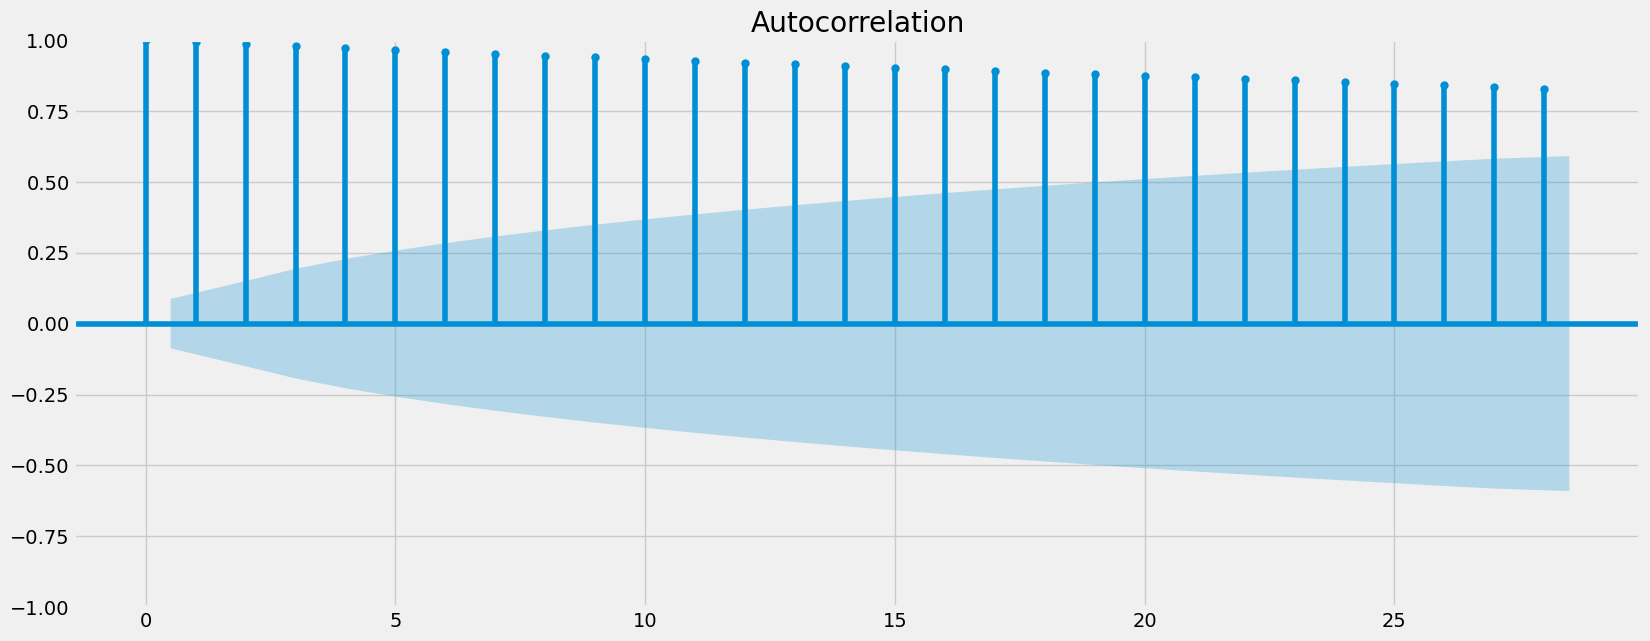

In [32]:
# Autocorrelation before stationarizing data

plot_acf(data_sub)
plt.show()

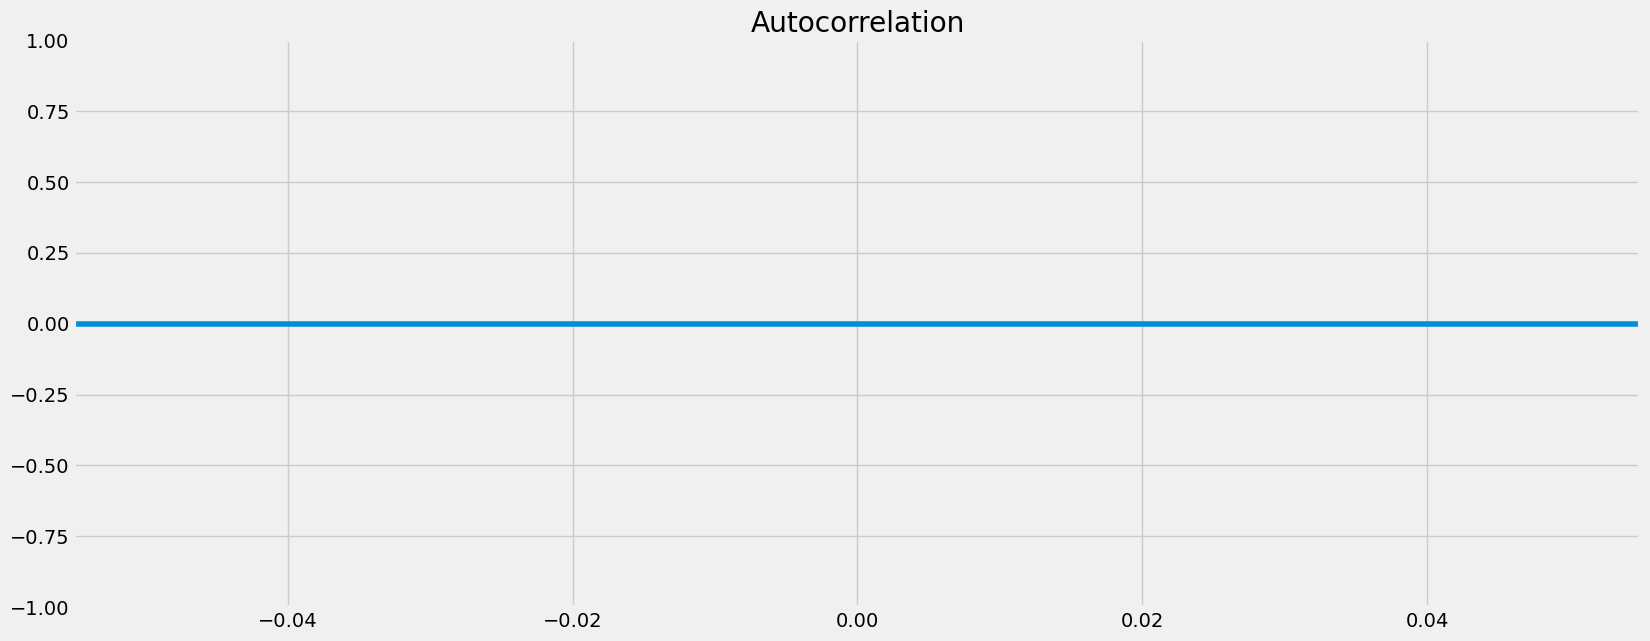

In [33]:
# Autocorrelation before stationarizing data

plot_acf(data_diff)
plt.show()

#### While the first autocorrelation graph confirms that the time series initially, before stationarizing, was non-stationary, the second autocorrelation graph confirms that the differencing technique for stationarizing the time series was successful, and the time series is now stationary.